## 1. Get X and Y, resize images to 224 x 224

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

%matplotlib inline

## 2. Image file path list

In [3]:
#Load the training and testing data, X is images, y are labels
BASE_IM_DIR = '/Users/Gabrielle/Kaggle/dog_breeds/train'

img_list = [file_name for file_name in os.listdir(BASE_IM_DIR) if file_name.endswith('jpg')]
img_list[:5]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg']

## 3. Query image

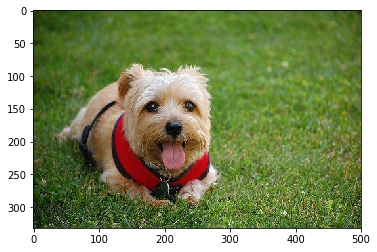

In [27]:
query_img_index = 14 # the cutest one

query_img_name = img_list[query_img_index]
query_img_path = os.path.join(BASE_IM_DIR, query_img_name)

plt.figure()
query_img = cv2.imread(query_img_path)
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
plt.imshow(query_img)

## 4a. Image search using Pretrained VGG16 Keras Model

In [5]:
from keras import applications
pretrained_vgg_16 = applications.VGG16(weights='imagenet', include_top = True)
from keras.models import Model
intermediate_layer_model = Model(inputs=pretrained_vgg_16.input,
                                 outputs=pretrained_vgg_16.get_layer('fc2').output)

Using TensorFlow backend.
/Users/Gabrielle/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Image vectors

In [6]:
feature_vec_list = []
for im_ind, im_file_path in enumerate(img_list):
    if im_ind % 100 ==0:
        print (im_ind)
    # reading the image
    img = cv2.imread(os.path.join(BASE_IM_DIR, im_file_path))
    # converting from bgr to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resizing
    img = cv2.resize(img,(224,224))
    # add dummy dimension
    img = img[None]
    # extract a feature vec for each image
    feature_vec = intermediate_layer_model.predict(img)
    # cocatenating the feature vectors to one big list
    feature_vec_list.append(feature_vec.ravel())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200


### K nearest neighbors

In [7]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)

neigh.fit(feature_vec_list)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

In [28]:
query_img_feature_vec = feature_vec_list[query_img_index]
distances, indices = neigh.kneighbors(query_img_feature_vec[None])
nn_img_names = [os.path.join(BASE_IM_DIR, img_list[img_index]) for img_index in indices.ravel()]

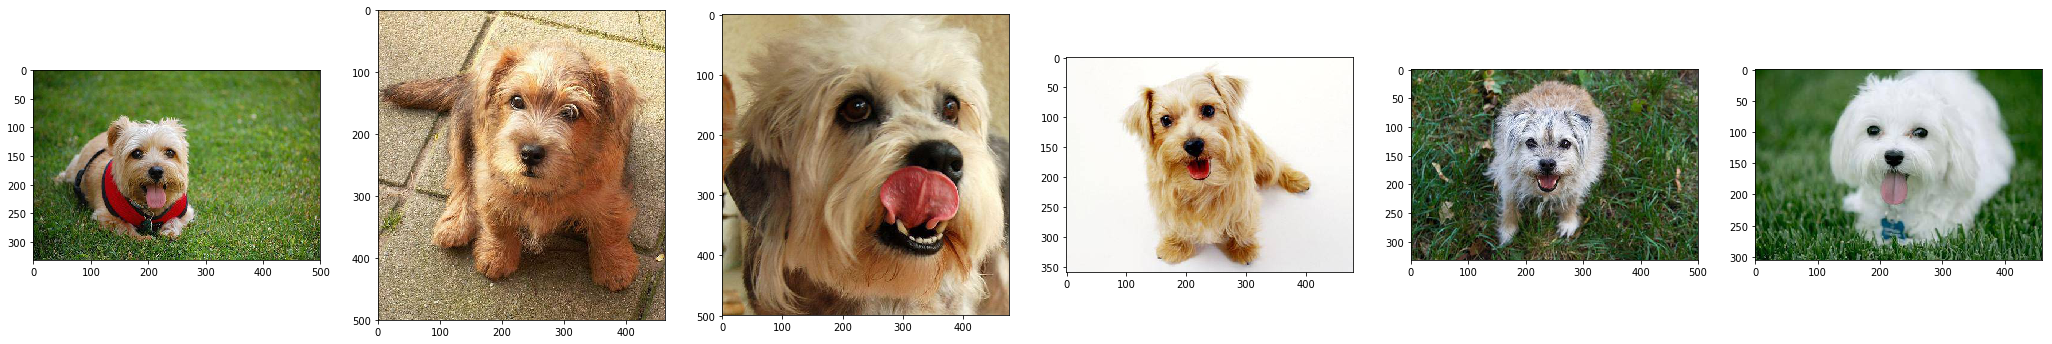

In [29]:
fig = plt.figure()
for nn_index, nn_img in enumerate(nn_img_names):
    image = cv2.imread(nn_img) # output image is blue tinted in BGR. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
    plt.subplot(1, 6, nn_index+1)
    plt.imshow(image)
fig.set_size_inches(fig.get_size_inches() * 6)
plt.show()

## 4b. Image Search using features in the pickle (resnet, features extracted by Gil)

### Image Vectors

In [30]:
import pickle

with open('/Users/Gabrielle/Kaggle/dog_breeds/dogs_features_dict.pickle', 'rb') as f:
    data = pickle.load(f, encoding = 'latin1') # dict with key = image_name, value = feature_vector
# Note: resnet data is ordered differently from the training set, have to search by key = image name.

resnet_img_list = list(data.keys())
resnet_feature_vec_list = list(data.values())

### K nearest neighbors

In [31]:
from sklearn.neighbors import NearestNeighbors
resnet_neigh = NearestNeighbors(n_neighbors=6)

resnet_neigh.fit(resnet_feature_vec_list)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

In [32]:
resnet_query_img_fecture_vec = data[query_img_name]
resnet_distances, resnet_indices = resnet_neigh.kneighbors(resnet_query_img_fecture_vec[None])
resnet_nn_img_names = [os.path.join(BASE_IM_DIR, resnet_img_list[img_index]) for img_index in resnet_indices.ravel()]

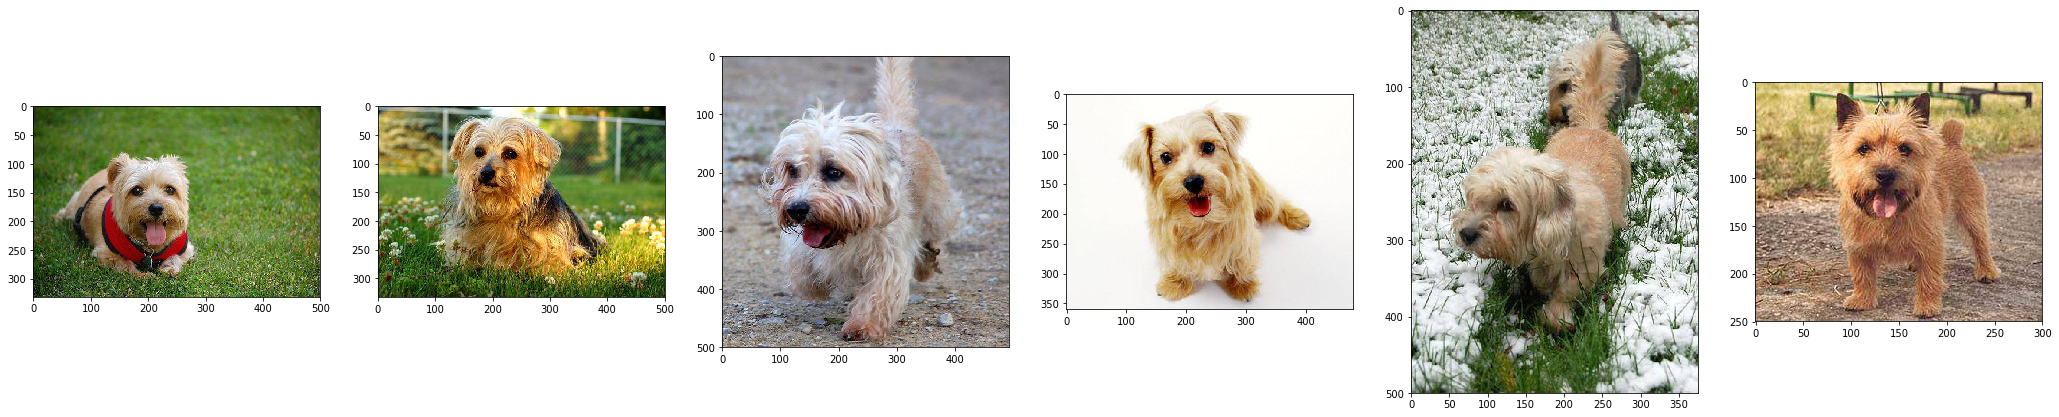

In [33]:
fig = plt.figure()
for nn_index, nn_img in enumerate(resnet_nn_img_names):
    image = cv2.imread(nn_img) # output image is blue tinted in BGR. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
    plt.subplot(1, 6, nn_index+1)
    plt.imshow(image)
fig.set_size_inches(fig.get_size_inches() * 6)
plt.show()

### Resnet is much better...

## 5. Lets do label classification - get X feature vectors and Y labels

In [35]:
X = list(data.values()) #image_feature_vectors
image_names = list(data.keys())
image_names_trimmed = [im_name.split('.')[0] for im_name in image_names]

labels_df = pd.read_csv('/Users/Gabrielle/Kaggle/dog_breeds/labels.csv') # id = image_name, breed = breed
# print(labels_df['breed'].values)

Y_list = []
for im_name in image_names_trimmed:
    breed_label = labels_df[labels_df['id'] == im_name]['breed'].values[0]
    # print(breed_label)
    Y_list.append(breed_label)

### Divide X and Y to train and test - total ~10,000K images

In [36]:
X = np.array(X)
X_train = X[:7000]
Y_train = Y_list[:7000]

X_val = X[7000:9000]
Y_val = Y_list[7000:9000]

X_test = X[9000:]
Y_test = Y_list[9000:]

### 5a. Classification with SVN

In [37]:
from sklearn.svm import LinearSVC

# find best C
best_svm, best_C, best_acc = None, None, 0
for cur_C in [0.0001,0.0003, 0.001, 0.003, 0.01, 0.03,0.1,0.3,1.0]:
    svm = LinearSVC(C=cur_C)
    svm.fit(X_train, Y_train) #this takes care of all the SGD and all that 
    cur_acc = svm.score(X_val,Y_val)
    print ('acc of LinearSVC with C = {} is {}'.format(cur_C, cur_acc))
    if cur_acc > best_acc:
        best_svm, best_C, best_acc = svm, cur_C, cur_acc

acc of LinearSVC with C = 0.0001 is 0.819
acc of LinearSVC with C = 0.0003 is 0.8395
acc of LinearSVC with C = 0.001 is 0.8395
acc of LinearSVC with C = 0.003 is 0.8305
acc of LinearSVC with C = 0.01 is 0.8255
acc of LinearSVC with C = 0.03 is 0.8195
acc of LinearSVC with C = 0.1 is 0.816
acc of LinearSVC with C = 0.3 is 0.8145
acc of LinearSVC with C = 1.0 is 0.813


In [39]:
print(best_C)
best_svm.score(X_val, Y_val) # just checking

0.0003


0.83950000000000002

In [40]:
val_pred = svm.predict(X_val)
val_pred[:10]

array(['brabancon_griffon', 'shih-tzu', 'silky_terrier',
       'american_staffordshire_terrier', 'shih-tzu', 'chihuahua',
       'brittany_spaniel', 'labrador_retriever', 'gordon_setter',
       'malinois'],
      dtype='<U30')

In [41]:
Y_val[:10]

['brabancon_griffon',
 'shih-tzu',
 'silky_terrier',
 'whippet',
 'shih-tzu',
 'chihuahua',
 'brittany_spaniel',
 'labrador_retriever',
 'gordon_setter',
 'malinois']

In [42]:
correct_predictions = np.sum(val_pred == Y_val)
total_predictions = len(Y_val)

In [43]:
print('{} out of {} dogs were classified correctly using SVM'.format(correct_predictions, total_predictions))

1626 out of 2000 dogs were classified correctly using SVM
